# Project Report

# **Using age, cholesterol and heart rate to classify heart disease patients from Cleveland.**
#### Shreya Arora, Youssef Saleh, Zahra Vink.

### Introduction
The term heart (cardiovascular) disease describes a range of heart conditions that arise from problems with the heart and blood vessels. One of these is coronary artery disease, which is when the arteries supplying blood to the heart narrow. Many risk factors can increase the chance of developing this disease, including cholesterol levels and maximum heart rate (Cleveland Clinic, n.d.). Age is also a factor, with older people being more likely to be diagnosed with heart disease (Rogers et al., 2019).

High levels of cholesterol result in fatty deposits in blood vessels that clog them, making it difficult for enough blood to flow through the arteries. When these deposits break suddenly, they form a clot resulting in a heart attack or stroke. If a patient has heart disease, their maximum heart rate could significantly decrease (WebMD, 2002). 

The goal of this project will be to use these risk factors to classify patients based on likeliness to have heart disease.

The question we will be addressing is: **Is a new patient likely to have heart disease, based on age, cholesterol levels and maximum heart rate achieved?**

### Preliminary exploratory data analysis

In [25]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

In [4]:
set.seed(1)
# reading the dataframe from URL, assigning col names and types
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"),
                           col_types = list("d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "d", "f", "f", "d"))

# cleaning, wrangling data
cleveland_data[ cleveland_data == "?" ] <- NA

cleveland_clean <- cleveland_data %>%
                    mutate(diag = as.factor(ifelse(is.na(num), NA, (num > 0)))) %>%
                    mutate(sex = as.factor(as.integer(sex)), cp = as.factor(as.integer(cp)), 
                           fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
                           exang = as.factor(as.integer(exang)), thal = as.factor(as.integer(thal)),
                           ca = as.factor(as.integer(ca)), slope = as.factor(as.integer(slope))) %>%
                    mutate(num = as_factor(num))


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,1,1,0,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,2,2,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,1,2,0,FALSE
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0,FALSE


**Training and Testing Split**

In the following code, we split the data into a training and testing set, the former for  building the classifier, and the latter for testing the classifier’s accuracy. Using initial_split to do this allowed us to shuffle the data before splitting (removing bias and order) and stratify the data by diagnosis so that an equal proportion of it in each set.  We are using a 75/25 split so that there is enough data in the training set to make an accurate classifier (more better accuracy) and then a reasonable amount of data in testing to test the accuracy of the classifier. 

In [22]:
#splitting dataframe into training, testing datasets
cleveland_split <- initial_split(cleveland_clean, prop = 3/4, strata = num)

cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

head(cleveland_training)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,2,2,2,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,3,3,1,TRUE
41,0,2,130,204,0,2,172,0,1.4,1,1,2,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,1,2,0,FALSE
62,0,4,140,268,0,2,160,0,3.6,3,3,2,3,TRUE
57,0,4,120,354,0,0,163,1,0.6,1,1,2,0,FALSE


In [23]:
#summarizing to get min, max, mean of each predictor + total no. of rows per class
cleveland_summary <- cleveland_training %>%
                    group_by(diag) %>%
                    summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
                              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol), 
                              min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach),
                              n_of_patients = n())

cleveland_summary

`summarise()` ungrouping output (override with `.groups` argument)



diag,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,min_thalach,max_thalach,mean_thalach,n_of_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,29,76,51.67480,141,394,236.6829,96,202,159.6504,123
TRUE,35,77,57.09434,131,341,250.4434,88,182,139.7264,106


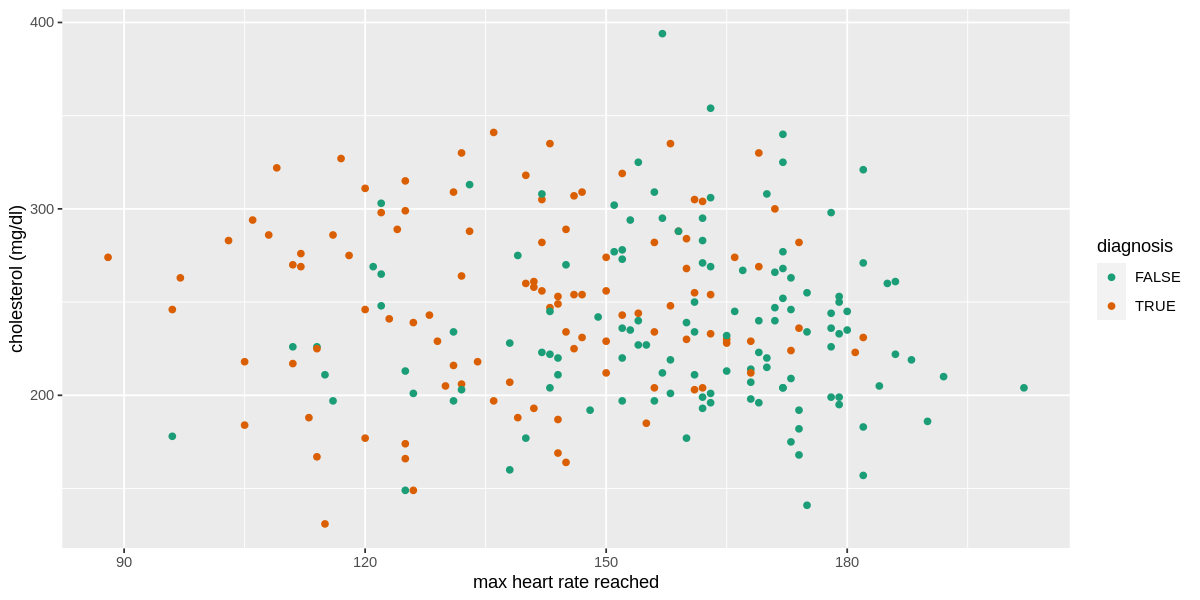

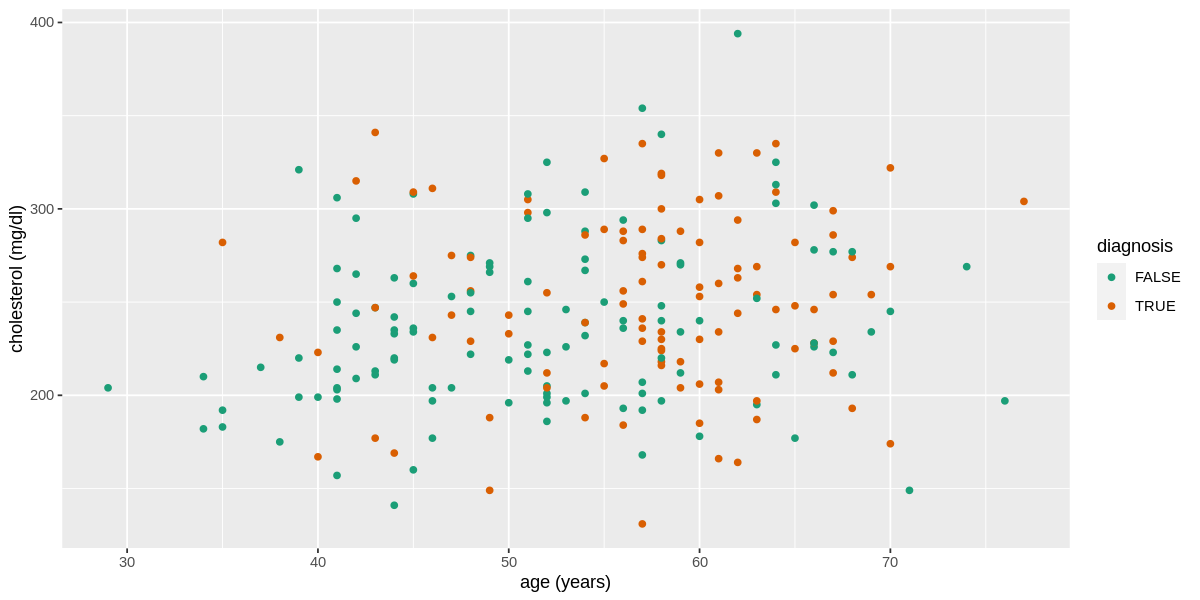

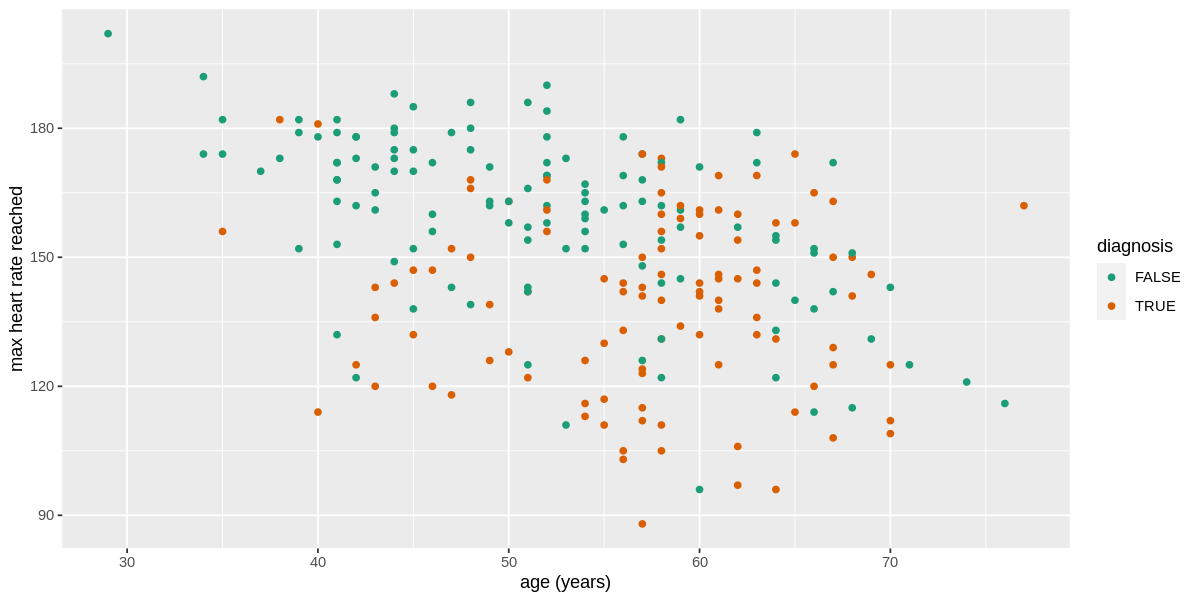

In [33]:
#plotting the training data
plot1 <- ggplot(cleveland_training, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "max heart rate reached", y = "cholesterol (mg/dl)", color = "diagnosis") +
                 scale_color_brewer(palette = "Dark2")

plot2 <- ggplot(cleveland_training, aes(x = age, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "age (years)", y = "cholesterol (mg/dl)", color = "diagnosis") +
                 scale_color_brewer(palette = "Dark2")

plot3 <- ggplot(cleveland_training, aes(x = age, y = thalach, color = diag)) +
                 geom_point() +
                 labs(x = "age (years)", y = "max heart rate reached", color = "diagnosis") +
                 scale_color_brewer(palette = "Dark2")

plot1
plot2
plot3

### Methods
We are using the processed.cleveland.data from the Heart Disease Database (originally collected from the Cleveland Clinic Foundation) to predict if a patient from Cleveland will have heart disease. The columns are as follows:
1. **age**: age
2. **sex**: sex (1 = male, 0 = female)
3. **cp**: chest pain type
4. **trestbps**: resting blood pressure in mmHg
5. **chol**: serum cholestoral in mg/dl
6. **fbs**: fasting blood sugar > 120 mg/dl? (1 = True, 0 = False)
7. **restecg**: resting electrocardiographic results
8. **thalach**: maximum heart rate achieved
9. **exang**: whether exercise induced angina (1 = True, 0 = False)
10. **oldpeak**: ST depression induced by exercise, relative to rest
11. **slope**: the slope of the peak exercise ST segment (1 = upslope, 2 = flat, 3 = downslope)
12. **ca**: number of major vessels (0-3) colored by flourosopy
13. **thal**: (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. **num**: diagnosis of heart disease (1,2,3,4 = presence, 0 = no presence)

Each column is numeric-valued and there are 303 rows, with missing data represented as the string "?".

To clean the data, we changed all "?" values into NA. Since **num** uses integers to distinguish presence (1,2,3,4) from absence (0), and we want to determine *whether or not* a patient has heart disease, a new boolean column **diag** has been appended to narrow diagnoses down to TRUE or FALSE.

We used initial_split() to split our dataframe into 75% training and 25% testing data, stratifying for **diag**. We used only the training set for analysis.

To summarize our data, we grouped by **diag** then summarized for the minimum, maximum and mean of each of **age**, **chol** and **thalach**. We noticed that the mean age of patients with heart disease is higher, as well as their cholesterol. Their maximum heart rate achieved was lower, on average.

To visualize relationships in our data, we generated scatter plots of different numerical (non-factor) variables against eachother. This helped us identify the best predictors to use, which eneded up aligning with our initial research (see introduction). When plotting **chol** vs **thalach**, and coloring our points based on **diag**, we could see three clear regions of TRUE diagnoses, FALSE diagnoses and an region of mixing of the two. Similarly distinct distributions were seen when visualizing **age** vs **chol** and **age** vs **thalach**.

### Data Analysis

**Methods for Finding Best K Value**

Methods for finding the best K value: 
Our goal is to find the best value for the K-nearest neighbours, providing the highest accuracy and better predictions. We had already split the data into a training and testing set initially, so in the code below, we create a classifier and perform cross-validation to split the training data, train the model with one set and use the other to evaluate it because we can not use testing data.

1) First, we use the recipe function, which preprocesses the data centered, scaled and balanced. 

2) Then we performed the cross-validation with ten folds using the vfold_cv function on the training data. We used ten folds because if we split the data once, the results strongly depend on the observations that ended up being in the validation set, so using more folds increases the accuracy.

3) Then we created a k nearest model but replaced neighbours=tune instead of an actual value since we are trying to find the best k-nearest neighbours value. 

4) We add the recipe and model to a workflow using workflow().Tune_grid function runs cross validation on a range of k nearest neighbours values that is specified in gridvals

5) Then we find the best K value by filtering for the accuracy and plotting a scatter plot with the accuracy estimate on the y axis and k nearest neighbour value on the x-axis. 


In [9]:
set.seed(1)

# Performing Standardization 
cleveland_recipe <- recipe(diag ~ chol + thalach , data = cleveland_training) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())

# Perform 10 fold-cross valdiation 
cleveland_vfold <- vfold_cv(cleveland_training, v = 10, strata = diag)

# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

gridvals <- tibble(neighbors = c(1:100))

# Create new workflow using new knn_tune 
knn_results <- workflow() %>%
      add_recipe(cleveland_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = cleveland_vfold, grid = gridvals) %>%
      collect_metrics()

#knn_results

neighbors,mean
<int>,<dbl>
73,0.7038702
74,0.7038702
83,0.6987813
84,0.6987813
57,0.6949769
77,0.6947958


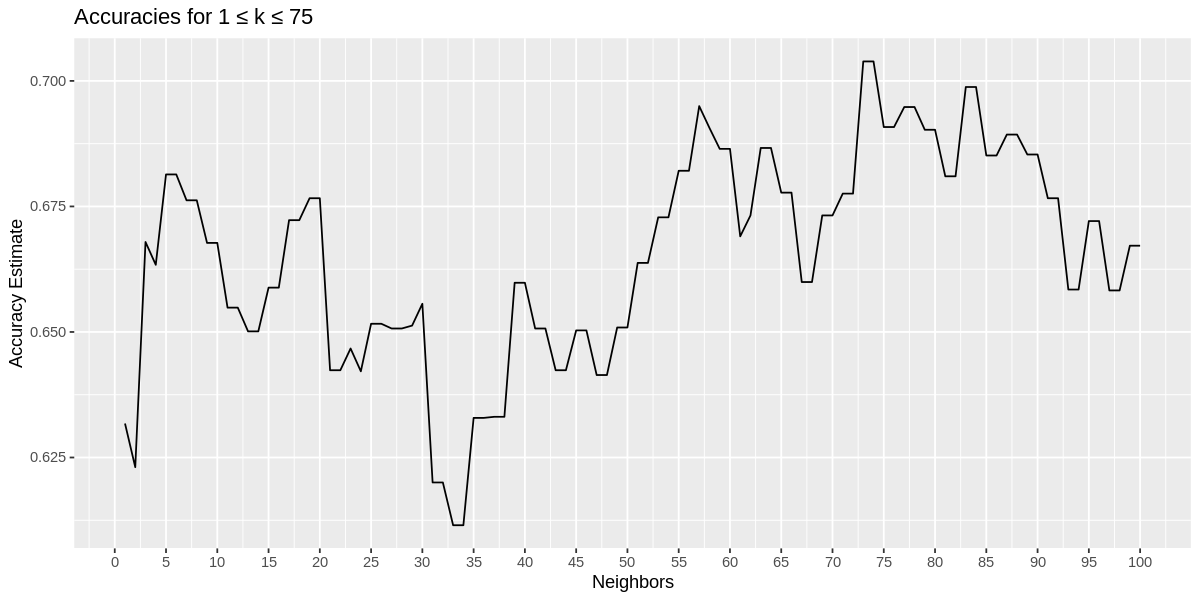

In [10]:
options(repr.plot.width = 10, repr.plot.height = 5)

#To find best k value filter for accuracies and graph
accuracies <- knn_results %>% 
      filter(.metric == "accuracy") %>%
      select(neighbors, mean) %>%
      arrange(desc(mean))

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      #geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ k ≤ 75") +
      scale_x_continuous(breaks = seq(0, 100, by = 5))  # adjusting the x-axis

accuracy_versus_k
head(accuracies)

**Looking at the graph above, $k$ = 73 give us the best accuracy, at 70%**

In the code cell below we used group_by and summarize to obtain the percentage of each class in the training set. From here we can deduce that a FALSE diagnosis represents the majority of the training data (53.9%).  Therefore, the majority classifier will most likely have 53.9% accuracy since it will always predict the majority class.

In [38]:
set.seed(1)

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 73)%>%
    set_engine("kknn")%>%
    set_mode("classification")

fit <- workflow()%>%
    add_recipe(cleveland_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = cleveland_training)

train_predictions <- predict(fit, cleveland_training)%>%
    bind_cols(cleveland_training)

thalach_grid <- seq(min(cleveland_clean$thalach), 
                max(cleveland_clean$thalach), 
                length.out = 100)

chol_grid <- seq(min(cleveland_clean$chol), 
                max(cleveland_clean$chol), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(thalach = thalach_grid, 
                                chol = chol_grid))

knnPredGrid <- predict(fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
                    rename(diag = .pred_class)


plot_results <- ggplot() + 
                geom_point(data = train_predictions, 
                mapping = aes(x = thalach, y = chol, color = diag), 
                alpha = 0.75) +
                geom_point(data = prediction_table, 
                           mapping = aes(x = thalach, 
                           y = chol, 
                           color = diag), 
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", 
                     color = "Diagnosis", 
                     title = "Regions of each diagnosis") +
                scale_color_brewer(palette = "Dark2") +
                theme(text = element_text(size = 20))

`summarise()` ungrouping output (override with `.groups` argument)



diag,n,percent
<fct>,<int>,<dbl>
FALSE,123,53.71179
TRUE,106,46.28821


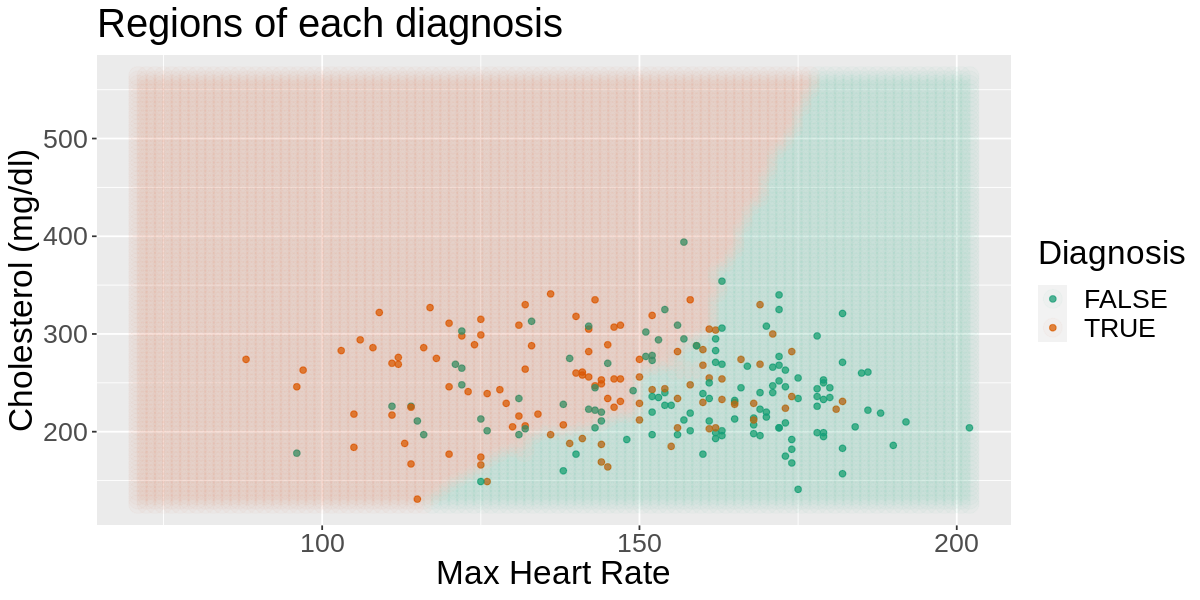

In [39]:
#Comparing accuracy of classifier with majority classifier
cleveland_proportions <-cleveland_training %>%
    group_by(diag) %>%
    summarize(n=n()) %>%
    mutate(percent = 100*n/nrow(cleveland_training))
cleveland_proportions
plot_results

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
FALSE,63,1,1,145,233,1,2,150,0,2.3,3,1,1,0,FALSE
FALSE,37,1,3,130,250,0,0,187,0,3.5,3,1,2,0,FALSE
FALSE,53,1,4,140,203,1,2,155,1,3.1,3,1,3,1,TRUE
FALSE,69,0,1,140,239,0,0,151,0,1.8,1,3,2,0,FALSE
TRUE,55,1,4,132,353,0,0,132,1,1.2,2,4,3,3,TRUE
TRUE,61,1,3,150,243,1,0,137,1,1.0,2,1,2,0,FALSE


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
FALSE,44,1,3,120,226,0,0,169,0,0.0,1,1,2,0,FALSE
FALSE,42,1,3,130,180,0,0,150,0,0.0,1,1,2,0,FALSE
FALSE,57,1,2,154,232,0,2,164,0,0.0,1,4,2,1,TRUE
FALSE,56,1,2,130,221,0,2,163,0,0.0,1,1,3,0,FALSE
FALSE,55,0,2,132,342,0,0,166,0,1.2,1,1,2,0,FALSE
TRUE,59,1,4,164,176,1,2,90,0,1.0,2,3,1,3,TRUE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6351351


          Truth
Prediction FALSE TRUE
     FALSE    24   10
     TRUE     17   23

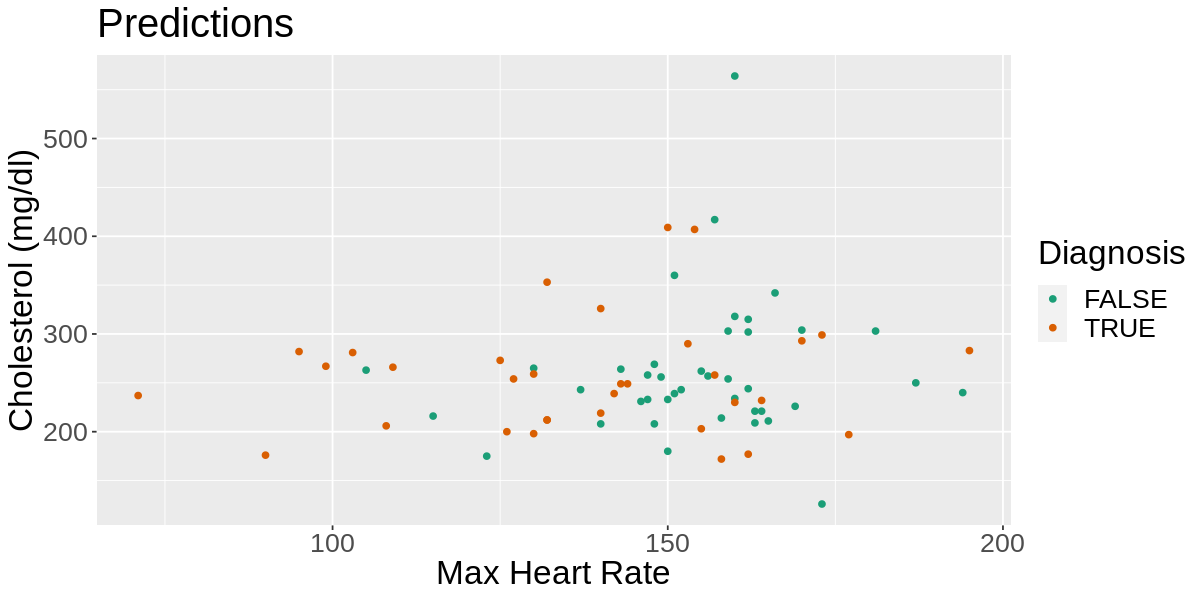

In [40]:
set.seed(1)

#build the model
#model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 73)%>%
    set_engine("kknn")%>%
    set_mode("classification")

#workflow
fit<- workflow()%>%
    add_recipe(cleveland_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = cleveland_training)

#predict
predictions<- predict(fit, cleveland_testing)%>%
    bind_cols(cleveland_testing)

head(predictions)
tail(predictions)

#find the accuracy of the predictions
metrics<- predictions %>%
    metrics(truth = diag, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat<- predictions %>%
    conf_mat(truth = diag, estimate = .pred_class)
conf_mat

#visualizing results

plot_results <- ggplot(predictions, aes(x = thalach, y = chol, color = diag)) +
                 geom_point() +
                 labs(x = "Max Heart Rate", y = "Cholesterol (mg/dl)", color = "Diagnosis") +
                 ggtitle("Predictions")+
                 scale_color_brewer(palette = "Dark2")+
                 theme(text = element_text(size = 20))
plot_results